In [15]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

'nm_2.dat'

In [76]:

#carregando os nomes dos arquivos
path = '/home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/'
#2025/07/16
archives = os.listdir(path)
#limpandos os nomes dos arquivos e estocando em novos e velhos nas variaveis
#files_new=sorted([archive for archive in archives if archive.split('_')[0] =='nm' if archive.split('.')[1] =='dat'],key=len)
files_new = sorted(
    f for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f))
    and f.startswith("nm_")
    and f.endswith(".dat")
)
file_old=sorted([archive for archive in archives if archive.split('_')[0] =='2ome' if archive.split('.')[1] =='dat'],key=len)
# lista de arquivos de parametros de qualidade
quality_files=sorted(
    f for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f))
    and f.startswith("nm_")
    and f.endswith(".ver")
) 
#archives
#quality_files[3]
files_new[3]
#olhe qual o arquivo te interssa
#olhe qual o indice do nome dele
#indice do arquivo: x
x=3

def df_otimization(x, path,files_new,quality_files):
    file = path+files_new[x]
    seq,tm_exp,tm_pred,tm_erro=tm_very(file)
    erro=quality_param(path+quality_files[x])
    columns_names= 'seq tm_exp tm_pred tm_erro'.split()
    #print(columns_names)
    #cria um dataframe vazio
    print(f'Voce utilizara o conjunto de parametros obtido dos {files_new[x].split(".")[0].split("_")[1]} melhores conjuntos')
    df=pd.DataFrame()
    for i,j in zip(columns_names,tm_very(file)):
        df[i]=j
    print(erro)
    return df,erro
df,erro = df_otimization(x, path,files_new,quality_files)
df
print(erro)

Voce utilizara o conjunto de parametros obtido dos 2 melhores conjuntos
0.693895
0.693895


In [143]:
#file=files_new[-1]
#estudando os arquivos
def tm_very(file):
    '''recebe o arquivo .dat com os resultados das predicoes e 
    retorna tres listas:
    tms experimentais, preditas e a diferenca entre elas
    nesta ordem.
    
    Para selecionar use:
    tm_exp,tm_pred,erro=tm_very(file)

    obs:
    este script serve para analise do arquivo .dat do tfreg
    ''' 
    seq = [] #sequencias
    tm = [] # tm experimental
    pred = [] # tm predita
    erro = [] # tm-pre
    # abrir os arquivos com as predicoes
    with open(file,'r') as f:
        lines=f.readlines()
        for line in lines[1:-3]:
            entry=line.split()
            #print(entry[4],entry[6],'\n') # tm expe, tm predita
            #print(f"desvio: {}")
            # estocar os resultados
            seq.append(entry[0])
            tm.append(float(entry[4]))
            pred.append(round(float(entry[6]),2))
            erro.append(float(entry[4])-round(float(entry[6]),2))
    return seq, tm, pred, erro
# extraindo o erro do arquivo de parametros de qualidade
def quality_param(file,position=1):
    '''
    quality_param(file,position=1):
    recebe o arquivo de parametros de qualidade,
    saida do TfReg com extensao .ver,
    e a posicao do parametro desejado
    na seguinte ordem
    
    posicao , parametro
    1: <T>; erro medio 
    2: delta(Delta T) desvio padrao
    3: chi^2
    4: <Delta Tm>RMS desvio medio quadratico
    5: <Delta Tm/Tm>RMS desvio medio ponderado()
    6: N
    '''

    with open(file) as f:
        param=f.readlines()[1].split()[position]
        return param
#file=quality_files[0]
#print(quality_param(file,6))

def scatter_error(df, fs, n, path,nome,erro,save=False):  
    plt.figure(figsize=fs)
    
    ax = sns.scatterplot(
        data=df,
        x="tm_exp",
        y="tm_pred",
        s=180,
        color="tab:blue",
        label="Predição"
    )
    
    ax.errorbar(
        df["tm_exp"],
        df["tm_pred"],
        yerr=df["tm_erro"].abs(),
        fmt="none",
        ecolor="black",
        capsize=5,
        elinewidth=0.6,
        alpha=0.5
    )
    
    # linha y=x (referência perfeita)
    maxx = df["tm_exp"].max()
    minx = df["tm_exp"].min()
    maxy = df["tm_pred"].max()
    miny = df["tm_pred"].min()
    lims = [
        min(minx, miny),
        max(maxx, maxy)
    ]
    #upper_strip=[]
    xaxis = df["tm_exp"]
    yaxis = df["tm_pred"]
    upper_strip = [float(i)+float(erro)  for i in xaxis]
    lower_strip = [float(i)-float(erro)  for i in xaxis]
    upper_outlier = [float(i)+2*float(erro)  for i in xaxis]
    lower_outlier = [float(i)-2*float(erro)  for i in xaxis]
    #sns.lineplot(x=xaxis,y=xaxis, label='limite superior')
    sns.lineplot(x=xaxis,y=upper_strip, label='limite superior', color="tab:gray")
    sns.lineplot(x=xaxis,y=lower_strip, label='limite inferior',color="tab:gray")
    sns.lineplot(x=xaxis,y=upper_outlier, label='outline superior', color="tab:red")
    sns.lineplot(x=xaxis,y=lower_outlier, label='outline inferior',color="tab:red")
    df_sorted = df.sort_values("tm_exp")
    xaxis = df_sorted["tm_exp"]
    upper_outlier = xaxis + 2 * float(erro)
    lower_outlier = xaxis - 2 * float(erro)
    plt.fill_between(
    xaxis,
    upper_outlier,
    lower_outlier,
    color="tab:gray",
    alpha=0.25
)
    ax.plot(lims, lims, "--", color="gray", label="Ideal")
    
    ax.set_xlabel(r"$T_m$ Experimental",fontsize=14)
    ax.set_ylabel(r"$T_m$ Predita",fontsize=14)
    ax.set_title("Tm experimental vs predita")
    ax.legend()
    #titulo=input("Insira o titulo")
    titulo =f'TM predita VS experimental para os parametros medios dos {n} melhores conjuntos'
    plt.title(titulo)
    plt.tight_layout()
    plt.annotate(
        '''
        A barra corresponde ao erro na predicao para cada sequencia no conjunto.\n
        A faixa vermelha corresponde a definicao de outlier para a predicao:\n
        Duas vezes o Erro medio no arquivo de parametros de qualidade.        
        ''',
        xy=(maxx-22,miny-3), 
        fontsize=12
    )
    if save:
        print(f'Salvando a figure em: {path+nome}.png')
        plt.savefig(f'{path}{nome}.png')
    plt.show()

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n2.png


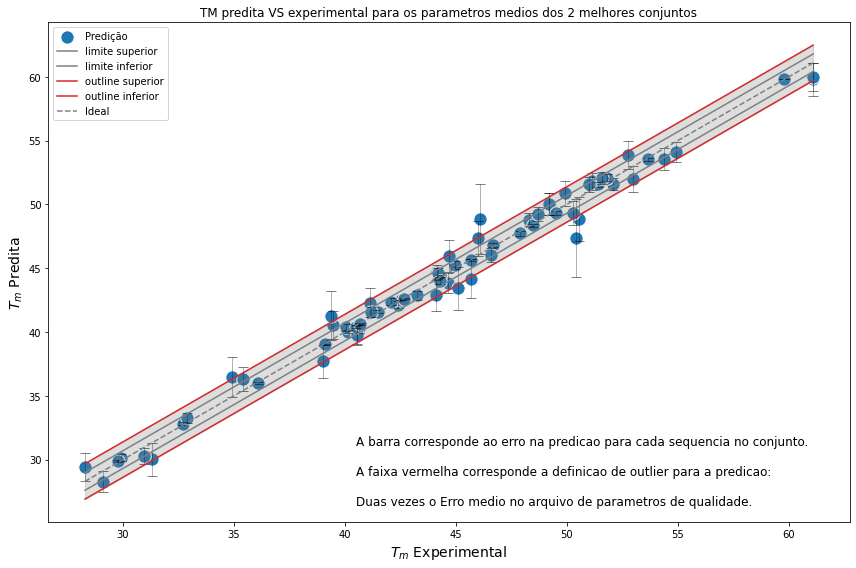

In [144]:
scatter_error(df, (12,8),2, path,'05_28_n2',erro, True)

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n10.png


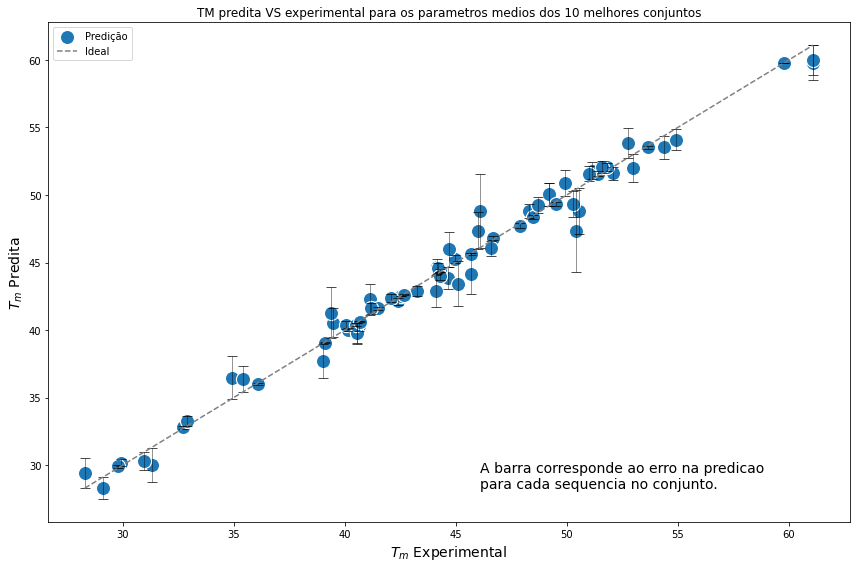

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n100.png


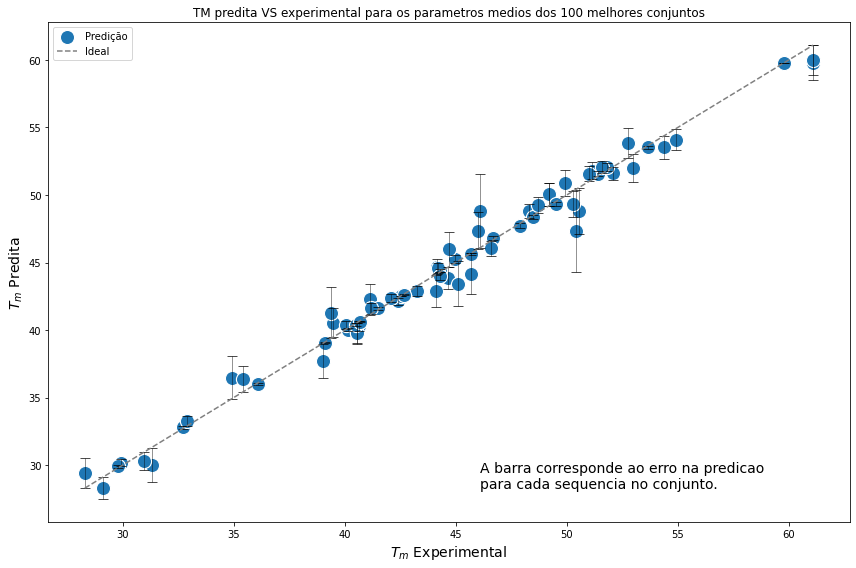

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n15.png


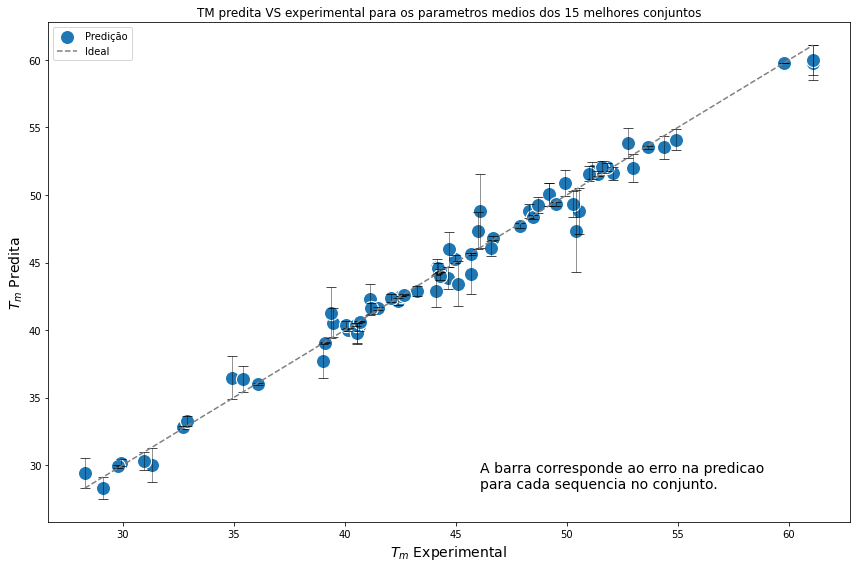

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n2.png


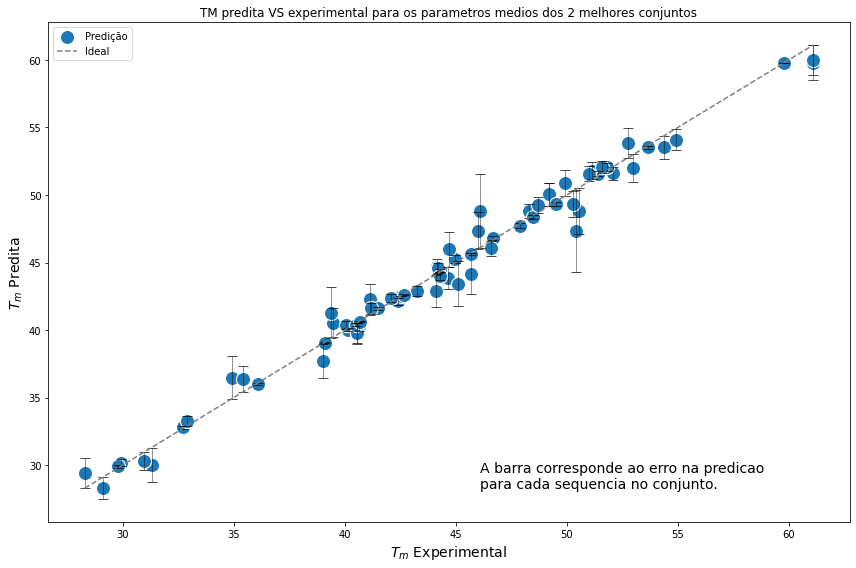

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n20.png


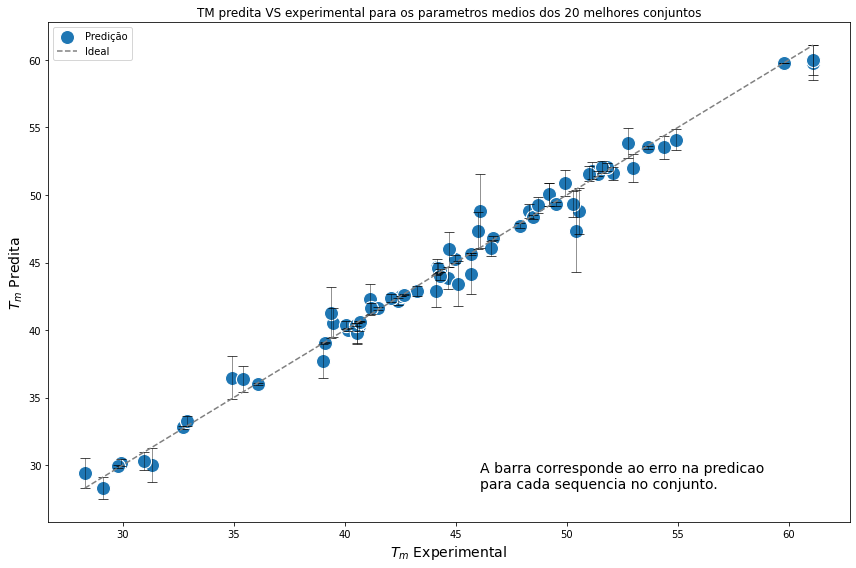

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n30.png


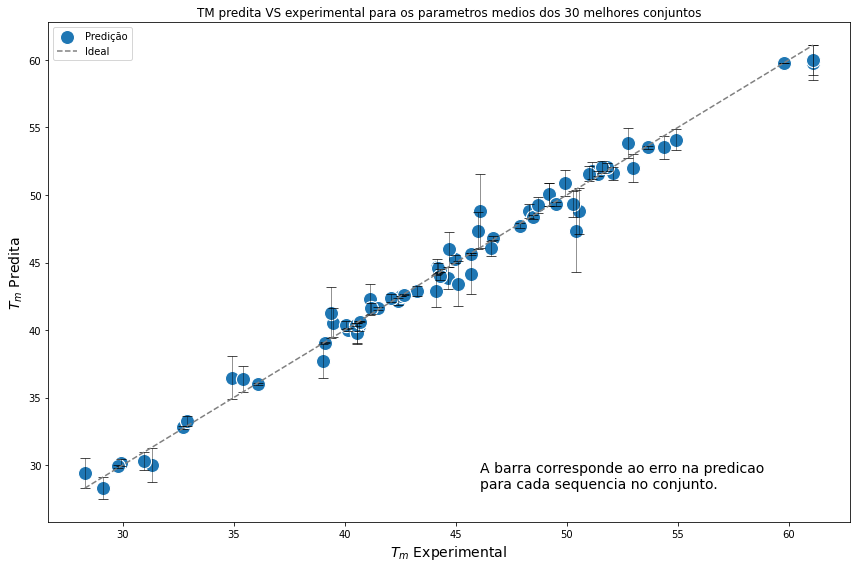

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n5.png


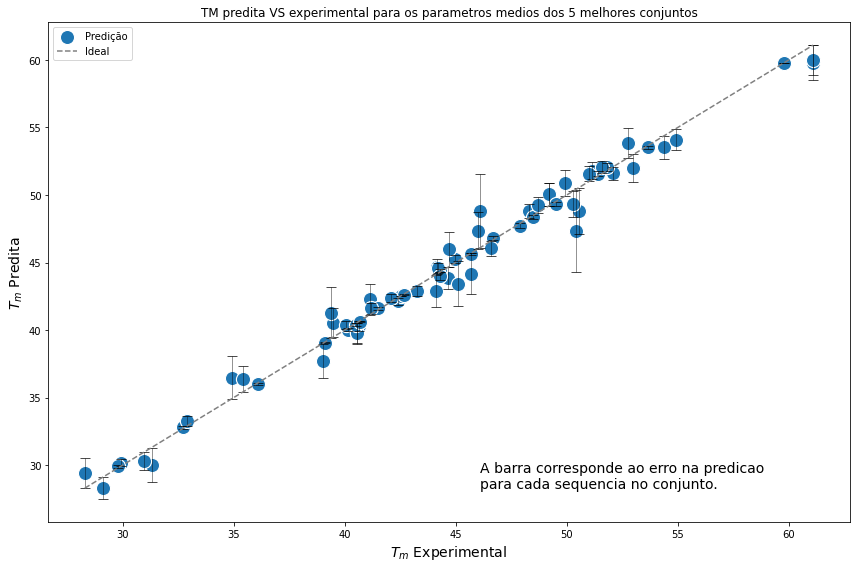

Salvando a figure em: /home/daniel/Desktop/geraldao/dados/NM/rna_nm/120mm/2025_05_28/05_28_n50.png


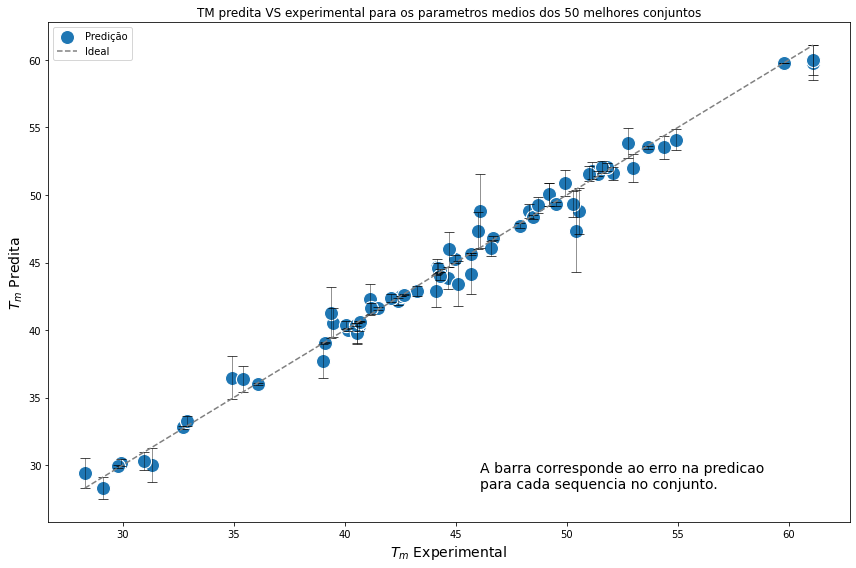

In [64]:
for i in files_new:
    x = i.split(".")[0].split("_")[1]
    df,erro = df_otimization(x, path,files_new,quality_files)
    scatter_error(df, (12,8),x, path,f'05_28_n{x}', True)
    